<a href="https://colab.research.google.com/github/ta3map/MonkeyResearch/blob/main/MonkeyResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalation of dependencies 
## For Google Colab

In [1]:
!git clone https://github.com/mariomulansky/PySpike.git

Cloning into 'PySpike'...
remote: Enumerating objects: 1798, done.
remote: Total 1798 (delta 0), reused 0 (delta 0), pack-reused 1798
Receiving objects: 100% (1798/1798), 16.53 MiB | 18.71 MiB/s, done.
Resolving deltas: 100% (1242/1242), done.


In [2]:
!cd PySpike && python setup.py install&> /dev/null

In [3]:
import sys
sys.path.insert(0,'/usr/local/lib/python3.7/dist-packages/pyspike-0.6.0-py3.7-linux-x86_64.egg')

In [4]:
!git clone https://github.com/ta3map/MonkeyResearch.git

Cloning into 'MonkeyResearch'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 66 (delta 6), reused 63 (delta 3), pack-reused 0
Unpacking objects: 100% (66/66), done.


## For standalone PC version:

In [3]:
main_folder = 'F:\YandexDisk\MonkeysDatas'
import os
os.chdir(main_folder)

---

# Analysis
## 1. Choose the data folder (data_1, data_2, data_3)

In [16]:
data_folder = 'data_1'

### Pre-sets
#### Loading libraries and data settings from the corresponding xlsx protocol file

In [186]:
import numpy as np
import pyspike as spk
from MonkeyResearch import SpFun
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from tqdm.notebook import tqdm

# read protocol
filepath = main_folder + '/MonkeyResearch/protocol/' + data_folder + '.xlsx'
protocol = pd.read_excel(filepath, sheet_name=0)
set_properties = pd.read_excel(filepath, sheet_name=1)
chosen_neuron_numbers = pd.read_excel(filepath, sheet_name=2)
neuron_names = protocol['neuron_name'].tolist()

# choose neurons
# 2 for all neurons
# 3 stable

chosen_neurons = SpFun.GetNeuronNumbers(2, chosen_neuron_numbers)
chosen_neuron_names = SpFun.GetNeuronNames(2, chosen_neuron_numbers)
chosen_neurons_number = len(chosen_neurons)

#% setA stimuli names and ranges
set_names = set_properties['set names'].tolist()
shows_number = int(set_properties['shows number'][0])
pictures_number = int(set_properties['pictures number'][0])
stimuli_number = len(set_names)
neurons_number = len(protocol)

### Load Data

In [18]:
filepath = main_folder + '/MonkeyResearch/data/' + data_folder + ''
with open(filepath, 'rb') as f:
    spikeTrains = pickle.load(f)
np.shape(spikeTrains)

(36, 8, 15, 20)

(neurons, categories, pictures, showings)

**data_1** and **data_2** have a shape (36, 8, 15, 20):
- 36 neurons
- 8 categories
- 15 pictures
- 20 showings

**data_3** has a shape (74, 12, 10, 20):
- 74 neurons
- 12 categories
- 10 pictures
- 20 showings

## 2. Extract spike-train parameters
### Directions

In [240]:
# get spike trains from the range (e.g. control or response times)
# getFromRange1D(spikeTrains[0,0,0,7]) # example
def getFromRange1D(Train, start_time, end_time):# for 1D spike train array
    return Train[(Train >= start_time) & (Train <= end_time)]
GetFromRange = np.vectorize(getFromRange1D, otypes=[object])# vectorization for multidimensional array

# changing the format according to PySpike library
def spikeTrain1D(Train, start_time, end_time):# for 1D spike train array
    edges = [start_time, end_time]
    if (np.size(Train)) == 0:
            Train = np.zeros(1)
            silent_neuron = True
    return spk.SpikeTrain(Train, edges)
SpikeTrains = np.vectorize(spikeTrain1D, otypes=[object])# vectorization for multidimensional array

# directionality matrix for single showing
def singleDirectionalityMatrix(spike_times, start_time, end_time):
    Trains = SpikeTrains(spike_times, start_time, end_time)
    direction = spk.spike_directionality_matrix(Trains, max_tau = 25)
    return direction
#DirectionalityMatrix = np.vectorize(singleDirectionalityMatrix, otypes=[object])

def DirectionalityMatrix(Trains, start_time, end_time):# for multidimensional array
    categories = np.size(Trains, 1)
    pictures = np.size(Trains, 2)
    shows = np.size(Trains, 3)
    data_c = []# category (baby, grooming ...)
    for c in tqdm(range(categories)):
        data_p = []# pictures(1, 2, 3 ...)
        for p in range(pictures):
            data_s = []# shows (1, 2, 3 ...)
            for s in range(shows):
                spike_times = Trains[:, c, p, s]
                data = singleDirectionalityMatrix(spike_times, start_time, end_time)
                data = np.squeeze(data)
                data_s.append(data)
            data_p.append(data_s)
        data_c.append(data_p)
    return np.array(data_c)

### All Spike Trains
that we can get from the **control** and the **response** ranges

In [241]:
controlTrains = GetFromRange(spikeTrains, start_time = -100, end_time = 0)
responseTrains = GetFromRange(spikeTrains, start_time = 100, end_time = 200)

### Example 1 - an instance of Directionality Matrix

An example of directionality matrix for **one showing**:
(**all neurons**, first category, first picture, first showing)

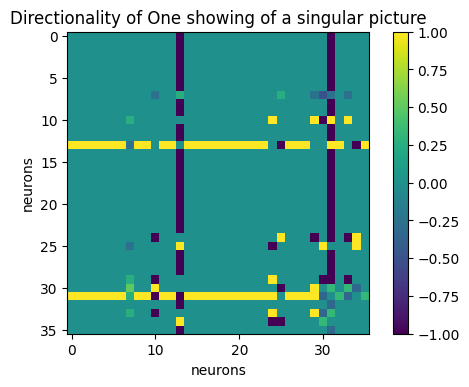

In [242]:
spike_times = controlTrains[:, 0, 0, 0]

Trains = SpikeTrains(spike_times, start_time = -1000, end_time = 1000)
direction = spk.spike_directionality_matrix(Trains, max_tau = 25)

plt.figure(0, dpi = 100)
plt.imshow(direction)
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.colorbar()
plt.title('Directionality of One showing of a singular picture');

1 is leader, -1 is follower

### All directionality matrices 
that we can get from the **control** and the **response** ranges

In [243]:
control_D = DirectionalityMatrix(controlTrains, -100, 0)
response_D = DirectionalityMatrix(responseTrains, 100, 200)
effect_D = response_D - control_D
np.shape(effect_D)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

(8, 15, 20, 36, 36)

Now we have **Directionality matrices of an effect** that correspond to all categories, all pictures, all showings. 

The shape is:
(categories, pictures, showings, neurons, neurons)


### Example 2 - average Directionality Matrix
Let's look at example of **average directionality matrix** of one picture from one category

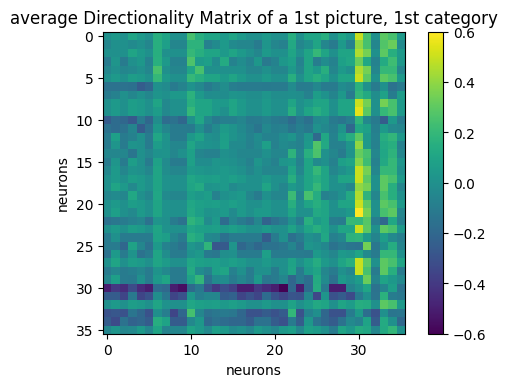

In [257]:
direction = np.mean(effect_D[0, 0, :], 0)# all showings of the first picture of the first category 
plt.figure(0, dpi = 100)
plt.imshow(direction)
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.colorbar()
plt.title('average Directionality Matrix of a 1st picture, ' + '1st category');

### All average Directionality Matrices

#### Sorting

### Graphs
#### Making a graph for each showing

In [ ]:
# load directions

#### Node degrees

In [ ]:
# Save in-degrees and out-degrees

#### Statistics